# Graph generation

In [ ]:
import networkx as nx
import numpy as np 
import random
import math 
from numpy.linalg import matrix_rank
from scipy import linalg

def get_adj(g):
  adj = np.zeros((len(g.nodes()),len(g.nodes())))
  #print(g.edges())
  for e in np.array(g.edges()):
    adj[e[0],e[1]] = 1
    adj[e[1],e[0]] = 1
  return adj


def getCycles(A,max_len=math.inf):
  ''''A = adj matrix'''
  ''''p_max_len = lenght if max cycles wanted, inf default for all cycles'''
  G = nx.DiGraph(A)
  cycles = nx.simple_cycles(G)
  final = []
  for elem in cycles:
    if sorted(elem) not in [sorted(x) for x in final]:
      final.append(elem)
  final = [c for c in final if len(c)>=3 and len(c)<= max_len]
  final.sort(key=len)
  return final


def create_B1(A):
  G = nx.Graph(A) #nx.from_numpy_matrix(A) #
  E_list = list(G.edges) 
  B1 = np.zeros([len(G.nodes),len(E_list)])
  for n in G.nodes: 
    for e in E_list:
      if n==e[0]:
        B1[n,E_list.index(e)] = 1
      elif n==e[1]:
        B1[n,E_list.index(e)] = -1 
      else:
        B1[n,E_list.index(e)] = 0
  return B1


def create_B2(A,p_max_len=math.inf):
  ''''A = adj matrix'''
  ''''p_max_len = lenght if max cycles wanted, inf default for all cycles'''
  G = nx.Graph(A) # nx.from_numpy_matrix(A) #
  E_list = list(G.edges)
  All_P = getCycles(A,p_max_len)
  cycles = [x + [x[0]] for x in All_P]
  P_list = []
  for c in cycles:
    p = []
    for i in range(len(c)-1):
      p.append([c[i],c[i+1]])
    P_list.append(p)
  B2 = np.zeros([len(E_list),len(P_list)])
  for e in E_list:
    for p in P_list:
      if list(e) in p:
        B2[E_list.index(e),P_list.index(p)] = 1
      elif [e[1],e[0]] in p:
        B2[E_list.index(e),P_list.index(p)] = -1
      else:
        B2[E_list.index(e),P_list.index(p)] = 0
  qr = linalg.qr(B2,pivoting=True)
  B2 = B2[: ,sorted(qr[2])[:matrix_rank(B2)]]
  return B2

# create_ground_truth

In [16]:
import numpy as np
import numpy.linalg as la
import pandas as pd
from scipy.sparse.linalg import eigs


def compute_Lk_and_lambdak(L, K, separated=False):
    lambdas, _ = eigs(L)
    lambdas[np.abs(lambdas) < np.finfo(float).eps] = 0
    lambda_max = np.max(lambdas).real
    lambda_min = np.min(lambdas).real
    Lk = np.array([la.matrix_power(L, i) for i in range(1, K + 1)])
    # for the "separated" implementation we need a different dimensionality
    if separated:
        lambda_max_k = lambda_max ** np.arange(1, K + 1)
        lambda_min_k = lambda_min ** np.arange(1, K + 1)
    else:
        lambda_max_k = lambda_max ** np.array(list(np.arange(1, K + 1))+[0])
        lambda_min_k = lambda_min ** np.array(list(np.arange(1, K + 1))+[0])
    return Lk, lambda_max_k, lambda_min_k

def generate_coeffs(*arrays, s, mult=10):
    """ 
    Select ad hoc parameters for synthetic data generation, randomly over
    an interval dependent on the max eigenvalues of the Laplacian(s)
    """

    # if passing four arguments (two for upper and two for lower laplacian eigevals)
    # it means that you are using dictionary_type="separated"
    if len(arrays)==2:
        lambda_max_k, lambda_min_k = arrays
        K = lambda_max_k.shape[0]
        h = mult / np.max(lambda_max_k) * np.random.rand(s, K)
        # For later sanity check in optimization phase 
        tmp_max_vec = h @ lambda_max_k # parallelize the code with simple matrix multiplications
        tmp_min_vec = h @ lambda_min_k
        c = np.max(tmp_max_vec)
        tmp_sum_max = np.sum(tmp_max_vec)
        tmp_sum_min = np.sum(tmp_min_vec)

        Delta_min = c - tmp_sum_min
        Delta_max = tmp_sum_max - c
        epsilon = (Delta_max - Delta_min) * np.random.rand() + Delta_min

    elif len(arrays)==4:
        lambda_max_u_k, lambda_min_u_k, lambda_max_d_k, lambda_min_d_k = arrays
        K = lambda_max_u_k.shape[0]
        hI = mult / np.max(lambda_max_d_k) * np.random.rand(s, K)
        hS = mult / np.max(lambda_max_u_k) * np.random.rand(s, K)
        hH = mult / np.min([np.max(lambda_max_u_k), np.max(lambda_max_d_k)]) * np.random.rand(s, 1)
        h = [hS, hI, hH]
        # For later sanity check in optimization phase
        tmp_max_vec_S = (hS @ lambda_max_u_k).reshape(s,1)
        tmp_min_vec_S = (hS @ lambda_min_u_k).reshape(s,1)
        tmp_max_vec_I = (hI @ lambda_max_d_k).reshape(s,1)
        tmp_min_vec_I = (hI @ lambda_min_d_k).reshape(s,1)
        c = np.max(tmp_max_vec_I + tmp_max_vec_S + hH)
        tmp_sum_min = np.sum(tmp_min_vec_I + tmp_min_vec_S + hH)
        tmp_sum_max = np.sum(tmp_max_vec_I + tmp_max_vec_S + hH)
        Delta_min = c - tmp_sum_min
        Delta_max = tmp_sum_max - c
        epsilon = np.max([Delta_min, Delta_max])
    else:
        raise ValueError("Function accepts either 2 or 4 arrays! In case of 4 arrays are provided,\
                        the first 2 refer to upper laplacian and the other two to lower laplacian.")
    return h, c, epsilon, tmp_sum_min, tmp_sum_max

def generate_dictionary(h, s, *matrices):
    D = []
    # Always check if upper and lower Laplacians are separately provided
    if len(matrices)==1:
        Lk = matrices[0]
        n = Lk.shape[-1]
        k = Lk.shape[0]
        # iterate over each kernel dimension
        for i in range(0,s):
            # Replicate formula (8) of the paper for the i-th sub-dictionary
            h_tmp = h[i,:-1].reshape(k,1,1)
            tmp = np.sum(h_tmp*Lk, axis=0) + h[i,-1]*np.eye(n,n)
            D.append(tmp)
    elif len(matrices)==2:
        Luk , Ldk = matrices
        n = Luk.shape[-1]
        k = Luk.shape[0]
        # iterate over each kernel dimension
        for i in range(0,s):
            # Replicate formula (8) of the paper for the i-th sub-dictionary
            hu = h[0][i].reshape(k,1,1)
            hd = h[1][i].reshape(k,1,1)
            hid = h[2][i]
            tmp = np.sum(hu*Luk + hd*Ldk, axis=0) + hid*np.eye(n,n)
            D.append(tmp)
    else:
        raise ValueError("Function accepts one vector and either 1 or 2 matrices.")
    D = np.hstack(tuple(D))
    return D

def create_ground_truth(Lu, Ld, m_train, m_test, s, K, K0, dictionary_type, sparsity_mode):

    # Joint Dictionary Model
    if dictionary_type == "joint":
        Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Lu + Ld, K)
        h, c, epsilon, _, _ = generate_coeffs(lambda_max_k, lambda_min_k, s=s)
        D = generate_dictionary(h, s, Lk)

    # Edge Laplacian Dictionary Model
    elif dictionary_type == "edge_laplacian":
        Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Ld, K)
        h, c, epsilon, _, _ = generate_coeffs(lambda_max_k, lambda_min_k, s=s)
        D = generate_dictionary(h, s, Lk)

    # Separated Dictionary Model
    elif dictionary_type == "separated":
        Luk, lambda_max_u_k, lambda_min_u_k = compute_Lk_and_lambdak(Lu, K, separated=True)
        Ldk, lambda_max_d_k, lambda_min_d_k = compute_Lk_and_lambdak(Ld, K, separated=True)
        h, c, epsilon, _, _ = generate_coeffs(lambda_max_u_k, lambda_min_u_k, lambda_max_d_k, lambda_min_d_k, s=s)
        D = generate_dictionary(h, s, Luk, Ldk)

    n = D.shape[0]

    # Signal Generation
    def create_column_vec(row,n, s):
        tmp = np.zeros(n*s)
        tmp[row['idxs']]=row['non_zero_coeff']
        return tmp

    m_total = m_train + m_test
    tmp = pd.DataFrame()
    # Determine the sparsity for each column based on sparsity_mode
    if sparsity_mode == "max":
        tmp_K0 = np.random.choice(np.arange(1,K0+1), size=(m_total), replace=True)
    else:
        tmp_K0 = np.full((m_total,), K0)
    # sparsity coefficient for each column
    tmp['K0'] = tmp_K0
    # for each column get K0 indexes
    tmp['idxs'] = tmp.K0.apply(lambda x: np.random.choice(n*s, x, replace=False))
    # for each of the K0 row indexes in each column, sample K0 values
    tmp['non_zero_coeff'] = tmp.K0.apply(lambda x: np.random.randn(x))
    # create the column vectors with the desired characteristics
    tmp['column_vec'] = tmp.apply(lambda x: create_column_vec(x,n=n, s=s), axis=1)
    # finally derive the sparse signal representation matrix
    X = np.column_stack(tmp['column_vec'].values)

    all_data = D @ X
    X_train = X[:, :m_train]
    X_test = X[:, m_train:]
    train_Y = all_data[:, :m_train]
    test_Y = all_data[:, m_train:]

    return D, h, train_Y, test_Y, epsilon, c, X_train, X_test

# verify_dic


In [17]:
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit

def get_omp_coeff(K0, Domp, col):
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=K0)
    omp.fit(Domp, col)
    return omp.coef_

def verify_dic(D, Y_train, X_train_true, K0_max, acc_thresh):
    # OMP
    dd = la.norm(D, axis=0)
    W = np.diag(1. / dd)  # Normalization Step
    Domp = D @ W
    for K0 in range(1, K0_max+1):
        idx = np.sum(np.abs(X_train_true) > 0, axis=0) == K0  # select all column vectors with certain sparsity (K0 non-null elements)
        try:
            tmp_train = Y_train[:, idx]
            X_true_tmp = X_train_true[:, idx]
            idx_group = np.abs(X_true_tmp) > 0
            X_tr = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp.real, x), axis=0, arr=tmp_train)
            idx_train = np.abs(X_tr) > 0
            acc = np.sum(np.sum(idx_group == idx_train, axis=0) == idx_group.shape[0])/idx_group.shape[1]
            if acc < acc_thresh:
                fin_acc = acc
                break
            else:
                fin_acc = acc
        except:
            fin_acc=0
    max_possible_sparsity = K0 - 1
    return max_possible_sparsity, fin_acc

# initialize_dic

In [18]:
from sklearn.linear_model import OrthogonalMatchingPursuit
import scipy.linalg

def initialize_dic(Lu, Ld, s, K, Y_train, K0, dictionary_type, c, epsilon, only):

    n = Lu.shape[0]
    D = np.zeros((n, n*s))
    X = np.zeros(Y_train.shape)
    X = np.tile(X, (s,1))
    discard = 0

    # maybe is better to create a wrapper
    def multiplier_search(*arrays, s=s):
        is_okay = 0
        mult = 100
        tries = 0
        while is_okay==0:
            is_okay = 1
            h, c_try, _, tmp_sum_min, tmp_sum_max = generate_coeffs(arrays, s=s, mult=mult)
            if c_try <= c:
                is_okay *= 1
            if tmp_sum_min > c-epsilon:
                is_okay *= 1
                incr_mult = 0
            else:
                is_okay = is_okay*0
                incr_mult = 1
            if tmp_sum_max < c+epsilon:
                is_okay *= 1
                decr_mult = 0
            else:
                is_okay *= 0
                decr_mult = 1
            if is_okay == 0:
                tries += 1
            if tries >3:
                discard = 1
                break
            if incr_mult == 1:
                mult *= 2
            if decr_mult == 1:
                mult /= 2
        return h, discard

    if (only == "only_D") or (only == "all"):
        # Joint Dictionary Model
        if dictionary_type == "joint":
            Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Lu + Ld, K)
            h, discard = multiplier_search(lambda_max_k, lambda_min_k)
            D = generate_dictionary(h, s, Lk)

        # Edge Laplacian Dictionary Model
        elif dictionary_type == "edge_laplacian":
            Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Ld, K)
            h, discard = multiplier_search(lambda_max_k, lambda_min_k)
            D = generate_dictionary(h, s, Lk)

        # Separated Dictionary Model
        elif dictionary_type == "separated":
            Luk, lambda_max_u_k, lambda_min_u_k = compute_Lk_and_lambdak(Lu, K, separated=True)
            Ldk, lambda_max_d_k, lambda_min_d_k = compute_Lk_and_lambdak(Ld, K, separated=True)
            h, discard = multiplier_search(lambda_max_d_k, lambda_min_d_k, lambda_max_u_k, lambda_min_u_k)
            D = generate_dictionary(h, s, Luk, Ldk)
    
    if (only == "only_X" or only == "all"):
        
        if dictionary_type == "edge_laplacian":
            L = Ld
            # _, Dx = scipy.linalg.eig(L)
        else:
            L = Lu+Ld
            # _, Dx = scipy.linalg.eigh(L)

        _, Dx = scipy.linalg.eig(L)
        dd = la.norm(Dx, axis=0)
        W = np.diag(1./dd)
        Dx = Dx / la.norm(Dx)  
        Domp = Dx@W
        X = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp.real, x), axis=0, arr=Y_train)
        X = np.tile(X, (s,1))
        
    return D, X, discard

# topological_dictionary_learn

In [19]:
import numpy as np
import cvxpy as cp

def topological_dictionary_learn(Y_train, Y_test, K, n, s, D0, X0, Lu, Ld, dictionary_type, c, epsilon, K0, lambda_=1e-3, max_iter=10, patience=10, tol=1e-7, verbose=0):

    # Define hyperparameters
    min_error_train_norm, min_error_test_norm = 1e20, 1e20
    m_test, m_train = Y_test.shape[1], Y_train.shape[1]
    iter_, pat_iter = 1, 0

    if dictionary_type != "fourier":
        if dictionary_type=="joint":
            Lk, _, _ = compute_Lk_and_lambdak(Lu + Ld, K)
        elif dictionary_type=="edge_laplacian":
            Lk, _, _ = compute_Lk_and_lambdak(Ld, K)
        elif dictionary_type=="separated":
            Luk, _, _ = compute_Lk_and_lambdak(Lu, K, separated=True)
            Ldk, _, _ = compute_Lk_and_lambdak(Ld, K, separated=True)

        # Init the dictionary and the sparse representation 
        D_coll = [cp.Constant(D0[:,(n*i):(n*(i+1))]) for i in range(s)]
        Y = cp.Constant(Y_train)
        X_train = X0
        
        while pat_iter < patience and iter_ <= max_iter:
            
            # SDP Step
            # Init constants and parameters
            D_coll = [cp.Constant(np.zeros((n, n))) for i in range(s)]  # in the end we don't really need to init D in some way but all zeros will be fine?
            Dsum = cp.Constant(np.zeros((n, n)))
            X = cp.Constant(X_train)
            I = cp.Constant(np.eye(n))
            
            # Define the objective function
            if dictionary_type in ["joint", "edge_laplacian"]:
                # Init the variables
                h = cp.Variable((s, K))
                hI = cp.Variable((s, 1))
                for i in range(0,s):
                    tmp =  cp.Constant(np.zeros((n, n)))
                    for j in range(0,K):
                        tmp += (cp.Constant(Lk[j, :, :]) * h[i,j])
                    tmp += (I*hI[i])
                    D_coll[i] = tmp
                    Dsum += tmp
                D = cp.hstack([D_coll[i]for i in range(s)])
                term1 = cp.square(cp.norm((Y - D @ X), 'fro'))
                term2 = cp.square(cp.norm(h, 'fro')*lambda_)
                term3 = cp.square(cp.norm(hI, 'fro')*lambda_)
                obj = cp.Minimize(term1 + term2 + term3)

            else:
                # Init the variables
                hI = cp.Variable((s, K))
                hS = cp.Variable((s, K))
                hH = cp.Variable((s, 1))
                for i in range(0,s):
                    tmp =  cp.Constant(np.zeros((n, n)))
                    for j in range(0,K):
                        tmp += ((cp.Constant(Luk[j, :, :])*hS[i,j]) + (cp.Constant(Ldk[j, :, :])*hI[i,j]))
                    tmp += (I*hH[i])
                    D_coll[i] = tmp
                    Dsum += tmp
                D = cp.hstack([D_coll[i]for i in range(s)])
                
                term1 = cp.square(cp.norm((Y - D @ X), 'fro'))
                term2 = cp.square(cp.norm(hI, 'fro')*lambda_)
                term3 = cp.square(cp.norm(hS, 'fro')*lambda_)
                term4 = cp.square(cp.norm(hH, 'fro')*lambda_)
                obj = cp.Minimize(term1 + term2 + term3 + term4)

            # Define the constraints
            constraints = [D_coll[i] >> 0 for i in range(s)] + \
                            [(cp.multiply(c, I) - D_coll[i]) >> 0 for i in range(s)] + \
                            [(Dsum - cp.multiply((c - epsilon), I)) >> 0, (cp.multiply((c + epsilon), I) - Dsum) >> 0]

            prob = cp.Problem(obj, constraints)
            prob.solve(solver=cp.MOSEK, verbose=False)
            # Update the dictionary
            D = D.value

            # OMP Step
            dd = la.norm(D, axis=0)
            W = np.diag(1. / dd)
            Domp = D @ W
            X_train = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_train)
            X_test = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_test)
            # Normalize?
            X_train = W @ X_train
            X_test = W @ X_test

            # Error Updating
            error_train_norm = (1/m_train)* np.sum(la.norm(Y_train - (D @ X_train), axis=0)**2 /
                                    la.norm(Y_train, axis=0)**2)
            error_test_norm = (1/m_test)* np.sum(la.norm(Y_test - (D @ X_test), axis=0)**2 /
                                    la.norm(Y_test, axis=0)**2)

            # Error Storing
            if (error_train_norm < min_error_train_norm) and (abs(error_train_norm) > np.finfo(float).eps) and (abs(error_train_norm - min_error_train_norm) > tol):
                X_opt_train = X_train
                min_error_train_norm = error_train_norm

            if (error_test_norm < min_error_test_norm) and (abs(error_test_norm) > np.finfo(float).eps) and (abs(error_test_norm - min_error_test_norm) > tol):
                h_opt = h.value if dictionary_type in ["joint", "edge_laplacian"] else np.hstack([hI.value, hS.value, hH.value])
                D_opt = D
                X_opt_test = X_test
                min_error_test_norm = error_test_norm
                pat_iter = 0
                if verbose == 1:
                    print("New Best Test Error:", min_error_test_norm)
            else:
                pat_iter += 1

            iter_ += 1
    
    else:
        # Fourier Dictionary Benchmark
        L = Lu + Ld
        _, D_opt = scipy.linalg.eigh(L)
        dd = la.norm(D_opt, axis=0)
        W = np.diag(1./dd)  
        D_opt = D_opt / la.norm(D_opt)
        Domp = D_opt@W
        X_opt_train = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp.real, col=x), axis=0, arr=Y_train)
        X_opt_test = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp.real, col=x), axis=0, arr=Y_test)
        X_opt_train = W @ X_opt_train
        X_opt_test = W @ X_opt_test
        # Error Updating
        min_error_train_norm = (1/m_train)* np.sum(la.norm(Y_train - (D_opt @ X_opt_train), axis=0)**2 /
                                la.norm(Y_train, axis=0)**2)
        min_error_test_norm = (1/m_test)* np.sum(la.norm(Y_test - (D_opt @ X_opt_test), axis=0)**2 /
                                la.norm(Y_test, axis=0)**2)
        h_opt = 0
        
    return min_error_train_norm, min_error_test_norm, h_opt, X_opt_test, X_opt_train

## Define hyperparameters and graph strucutre

In [1]:
from tsplearn import *
import numpy as np 
import pandas as pd

# Load the graph
G = EnhancedGraph(n=40, p=0.162, seed=0)
B1 = G.get_b1()
B2 = G.get_b2()

# Sub-sampling if needed to decrease complexity
sub_size = 100
B1 = B1[:, :sub_size]
B2 = B2[:sub_size, :]
B2 = B2[:,np.sum(np.abs(B2), 0) == 3]

# Laplacians
Ld = np.matmul(np.transpose(B1), B1, dtype=float)
Lu = np.matmul(B2, np.transpose(B2), dtype=float)
L = Lu+Ld
n =  L.shape[0]
nu = B2.shape[1]
nd = B1.shape[1]

# Problem and Dictionary Dimensionalities
m_train = 150 # Number of Train Signals
m_test = 80 # Number of Test Signal
s = 3 # Number of Kernels (Sub-dictionaries)
k = 2 # Polynomial order
sparsity = .1 # Sparsity percentage
K0_max = 20 #floor(n*sparsity) # Sparsity
sparsity_mode = "max"

# Data-Independent Problem Hyperparameters
dictionary_type = ""
K0_coll = np.arange(5, 26, 4) 
max_iter = 100 
patience = 5 
tol = 1e-7 # tolerance for Patience
n_sim = 5
lambda_ = 1e-7 # l2 multiplier
verbose = True

## Dictionary generation

In [9]:
from tqdm import tqdm

dictionary_type = "joint"

D_true = np.zeros((n, n * s, n_sim))
D_true_coll = np.zeros((n, n, s, n_sim))
Y_train = np.zeros((n, m_train, n_sim))
Y_test = np.zeros((n, m_test, n_sim))
epsilon_true = np.zeros(n_sim)
c_true = np.zeros(n_sim)
X_train = np.zeros((n * s, m_train, n_sim))
X_test = np.zeros((n * s, m_test, n_sim))
n_search = 3000

for sim in range(n_sim):
    best_sparsity = 0
    best_acc = 0

    for i in tqdm(range(n_search)):
        try:
            D_try, h, Y_train_try, Y_test_try, epsilon_try, c_try, X_train_try, X_test_try = create_ground_truth(Lu,
                                                                                    Ld,
                                                                                    m_train,
                                                                                    m_test, 
                                                                                    s=s, 
                                                                                    K=k, 
                                                                                    K0=K0_max, 
                                                                                    dictionary_type=dictionary_type, 
                                                                                    sparsity_mode=sparsity_mode)
            
            max_possible_sparsity, acc = verify_dic(D_try, Y_train_try, X_train_try, K0_max, .7)
            if max_possible_sparsity > best_sparsity:
                best_sparsity = max_possible_sparsity
                best_acc = acc
                D_true[:, :, sim] = D_try
                Y_train[:, :, sim] = Y_train_try
                Y_test[:, :, sim] = Y_test_try
                epsilon_true[sim] = epsilon_try
                c_true[sim] = c_try
                X_train[:, :, sim] = X_train_try
                X_test[:, :, sim] = X_test_try

        except Exception as e:
            print(f"Error during dictionary creation: {e}")

    print(f"...Done! # Best Sparsity: {best_sparsity}")

100%|██████████| 3000/3000 [01:33<00:00, 31.92it/s]


...Done! # Best Sparsity: 4


100%|██████████| 3000/3000 [01:37<00:00, 30.93it/s]


...Done! # Best Sparsity: 5


100%|██████████| 3000/3000 [01:37<00:00, 30.61it/s]


...Done! # Best Sparsity: 3


100%|██████████| 3000/3000 [01:37<00:00, 30.69it/s]


...Done! # Best Sparsity: 4


100%|██████████| 3000/3000 [01:37<00:00, 30.74it/s]

...Done! # Best Sparsity: 4


In [13]:
import warnings

warnings.filterwarnings('ignore')

min_error_fou_train = np.zeros((n_sim, len(K0_coll)))
min_error_fou_test = np.zeros((n_sim, len(K0_coll)))
min_error_sep_train = np.zeros((n_sim, len(K0_coll)))
min_error_sep_test = np.zeros((n_sim, len(K0_coll)))
min_error_edge_train = np.zeros((n_sim, len(K0_coll)))
min_error_edge_test = np.zeros((n_sim, len(K0_coll)))
min_error_joint_train = np.zeros((n_sim, len(K0_coll)))
min_error_joint_test = np.zeros((n_sim, len(K0_coll)))

dict_errors = {
    "fou": (min_error_fou_train,min_error_fou_test),
    "edge": (min_error_edge_train,min_error_edge_test),
    "joint": (min_error_joint_train,min_error_joint_test),
    "sep": (min_error_sep_train,min_error_sep_test)
    }


dict_types = {
    "fou": ("Fourier","fourier"),
    "edge": ("Edge Laplacian", "edge_laplacian"),
    "joint": ("Hodge Laplacian","joint"),
    "sep": ("Separated Hodge Laplacian","separated")
    }

for sim in range(n_sim):
    c = c_true[sim]  
    epsilon = epsilon_true[sim] 
    for k0_index, k0 in tqdm(enumerate(K0_coll)):
        discard = 1
        while discard == 1:
            
            try:
                D0, X0, discard = initialize_dic(Lu, Ld, s, k, Y_train[:, :, sim], k0, dictionary_type, c, epsilon, "only_X")
            except:
                print("Initialization Failed!")

        for d in dict_types.items():
            try:
                dict_errors[d[0]][0][sim,k0_index], dict_errors[d[0]][1][sim,k0_index], _, _, _ = topological_dictionary_learn(Y_train[:,:,sim], Y_test[:,:,sim],
                                                                                                                            k, n, s, D0, X0, Lu, Ld, d[1][1],
                                                                                                                            c, epsilon, k0, lambda_, max_iter,
                                                                                                                            patience, tol)
                if verbose:
                    print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing {d[1][0]}... Done! Test Error: {dict_errors[d[0]][1][sim,k0_index]}")
            except:
                print(f'Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing {d[1][0]}... Diverged!')
                try:
                    dict_errors[d[0]][0][sim,k0_index], dict_errors[d[0]][1][sim,k0_index] = (dict_errors[d[0]][0][sim-1,k0_index]
                                                                                          , dict_errors[d[0]][1][sim-1,k0_index])
                except:
                    dict_errors[d[0]][0][sim,k0_index], dict_errors[d[0]][1][sim,k0_index] = (dict_errors[d[0]][0][sim+1,k0_index]
                                                                                          , dict_errors[d[0]][1][sim+1,k0_index])


0it [00:00, ?it/s]

Simulation: 1/5 Sparsity: 5 Testing Fourier... Done! Test Error: 0.2831006430351445
Simulation: 1/5 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.0730200074444142
Simulation: 1/5 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.029902848869239964


1it [00:59, 59.54s/it]

Simulation: 1/5 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.03235735190656156
Simulation: 1/5 Sparsity: 9 Testing Fourier... Done! Test Error: 0.16340370014754357
Simulation: 1/5 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.03656408878402008
Simulation: 1/5 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.009849249159724384


2it [01:56, 58.24s/it]

Simulation: 1/5 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.00992723834111883
Simulation: 1/5 Sparsity: 13 Testing Fourier... Done! Test Error: 0.10253750554148047
Simulation: 1/5 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.019642239363351802
Simulation: 1/5 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.003921500462248054


3it [03:47, 81.97s/it]

Simulation: 1/5 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.003794977897731343
Simulation: 1/5 Sparsity: 17 Testing Fourier... Done! Test Error: 0.06718957240387372
Simulation: 1/5 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.011277218682496338
Simulation: 1/5 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.0015457978782999796


4it [06:10, 106.20s/it]

Simulation: 1/5 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.002702673354630272
Simulation: 1/5 Sparsity: 21 Testing Fourier... Done! Test Error: 0.04647460264204383
Simulation: 1/5 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.00797350447779702
Simulation: 1/5 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.0015427580460728504


5it [09:19, 136.14s/it]

Simulation: 1/5 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.0016848893280352198
Simulation: 1/5 Sparsity: 25 Testing Fourier... Done! Test Error: 0.033471621822318644
Simulation: 1/5 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.004861344215562429
Simulation: 1/5 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.0009627275405541104


6it [14:10, 141.76s/it]


Simulation: 1/5 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.001064999036776857


0it [00:00, ?it/s]

Simulation: 2/5 Sparsity: 5 Testing Fourier... Done! Test Error: 0.2532428380001784
Simulation: 2/5 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.06200346666607903
Simulation: 2/5 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.01597485655826646


1it [00:45, 45.44s/it]

Simulation: 2/5 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.02036672569102579
Simulation: 2/5 Sparsity: 9 Testing Fourier... Done! Test Error: 0.1356327124199442
Simulation: 2/5 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.025785378570348752
Simulation: 2/5 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.005067297379581381


2it [01:49, 56.31s/it]

Simulation: 2/5 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.006666876504762151
Simulation: 2/5 Sparsity: 13 Testing Fourier... Done! Test Error: 0.07828409308456953
Simulation: 2/5 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.012279310019745361
Simulation: 2/5 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.0033618670570467442


3it [04:28, 103.10s/it]

Simulation: 2/5 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.00310945829013332
Simulation: 2/5 Sparsity: 17 Testing Fourier... Done! Test Error: 0.04969265141185204
Simulation: 2/5 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.0069333199519986954
Simulation: 2/5 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.0017212877588751294


4it [07:27, 133.23s/it]

Simulation: 2/5 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.002302599567418928
Simulation: 2/5 Sparsity: 21 Testing Fourier... Done! Test Error: 0.03383831359093894
Simulation: 2/5 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.005232997775322081
Simulation: 2/5 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.001449834394826705


5it [10:57, 160.84s/it]

Simulation: 2/5 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.0016134644921328577
Simulation: 2/5 Sparsity: 25 Testing Fourier... Done! Test Error: 0.0229852167968191
Simulation: 2/5 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.005076693648080397
Simulation: 2/5 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.0007967963765775775


6it [15:29, 154.84s/it]


Simulation: 2/5 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.001079779729838682


0it [00:00, ?it/s]

Simulation: 3/5 Sparsity: 5 Testing Fourier... Done! Test Error: 0.2616966483266171
Simulation: 3/5 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.09481468220085632
Simulation: 3/5 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.03479026583559402


1it [00:48, 48.73s/it]

Simulation: 3/5 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.03545529477847138
Simulation: 3/5 Sparsity: 9 Testing Fourier... Done! Test Error: 0.14365380565585692
Simulation: 3/5 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.05001575840838027
Simulation: 3/5 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.008785745644310504


2it [01:29, 43.94s/it]

Simulation: 3/5 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.01011349950256141
Simulation: 3/5 Sparsity: 13 Testing Fourier... Done! Test Error: 0.08802418658450237
Simulation: 3/5 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.025906545564895956
Simulation: 3/5 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.0037775919314862157


3it [02:50, 61.06s/it]

Simulation: 3/5 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.00397293837664568
Simulation: 3/5 Sparsity: 17 Testing Fourier... Done! Test Error: 0.055437352857308025
Simulation: 3/5 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.01551167694348
Simulation: 3/5 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.0019555204199342992


4it [04:58, 87.33s/it]

Simulation: 3/5 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.001955276528679631
Simulation: 3/5 Sparsity: 21 Testing Fourier... Done! Test Error: 0.03392533776780685
Simulation: 3/5 Sparsity: 21 Testing Edge Laplacian... Diverged!
Simulation: 3/5 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.0010328718584464


5it [07:37, 113.31s/it]

Simulation: 3/5 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.0016998282561940786
Simulation: 3/5 Sparsity: 25 Testing Fourier... Done! Test Error: 0.02253965670417505
Simulation: 3/5 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.005472669185551357
Simulation: 3/5 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.0011673645911443997


6it [12:15, 122.52s/it]


Simulation: 3/5 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.001124740512793819


0it [00:00, ?it/s]

Simulation: 4/5 Sparsity: 5 Testing Fourier... Done! Test Error: 0.2634458644425148
Simulation: 4/5 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.11373484236665524
Simulation: 4/5 Sparsity: 5 Testing Hodge Laplacian... Diverged!


1it [00:22, 22.66s/it]

Simulation: 4/5 Sparsity: 5 Testing Separated Hodge Laplacian... Diverged!
Simulation: 4/5 Sparsity: 9 Testing Fourier... Done! Test Error: 0.14796712209258514
Simulation: 4/5 Sparsity: 9 Testing Edge Laplacian... Diverged!
Simulation: 4/5 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.015293961236135717


2it [00:52, 27.01s/it]

Simulation: 4/5 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.01563693295938298
Simulation: 4/5 Sparsity: 13 Testing Fourier... Done! Test Error: 0.09002705912454685
Simulation: 4/5 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.031103065617970715
Simulation: 4/5 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.006530759818636239


3it [02:09, 49.85s/it]

Simulation: 4/5 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.007084261665292688
Simulation: 4/5 Sparsity: 17 Testing Fourier... Done! Test Error: 0.055453583693328284
Simulation: 4/5 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.01931071305718224
Simulation: 4/5 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.003470138471027572


4it [03:27, 61.01s/it]

Simulation: 4/5 Sparsity: 17 Testing Separated Hodge Laplacian... Diverged!
Simulation: 4/5 Sparsity: 21 Testing Fourier... Done! Test Error: 0.03672933615318369
Simulation: 4/5 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.027118467505839974
Simulation: 4/5 Sparsity: 21 Testing Hodge Laplacian... Diverged!


5it [03:56, 49.49s/it]

Simulation: 4/5 Sparsity: 21 Testing Separated Hodge Laplacian... Diverged!
Simulation: 4/5 Sparsity: 25 Testing Fourier... Done! Test Error: 0.02469095805032913
Simulation: 4/5 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.008686558599810925
Simulation: 4/5 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.0013184297063340616


6it [07:21, 73.56s/it] 


Simulation: 4/5 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.003208366423780584


0it [00:00, ?it/s]

Simulation: 5/5 Sparsity: 5 Testing Fourier... Done! Test Error: 0.25641432335648473
Simulation: 5/5 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.10158959925288268
Simulation: 5/5 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.040992899625020014


1it [00:39, 39.20s/it]

Simulation: 5/5 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.04260202830711403
Simulation: 5/5 Sparsity: 9 Testing Fourier... Done! Test Error: 0.1403097467997738
Simulation: 5/5 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.04618339976363274
Simulation: 5/5 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.012690765244767671


2it [01:30, 46.03s/it]

Simulation: 5/5 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.012754170538723297
Simulation: 5/5 Sparsity: 13 Testing Fourier... Done! Test Error: 0.08444710168138014
Simulation: 5/5 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.025311254464404423
Simulation: 5/5 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.005413582458590516


3it [02:43, 58.51s/it]

Simulation: 5/5 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.005280969422365457
Simulation: 5/5 Sparsity: 17 Testing Fourier... Done! Test Error: 0.05309299798824596
Simulation: 5/5 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.014711757044778347
Simulation: 5/5 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.0027091691950248045


4it [05:06, 91.99s/it]

Simulation: 5/5 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.002454715111136804
Simulation: 5/5 Sparsity: 21 Testing Fourier... Done! Test Error: 0.03528003680033576
Simulation: 5/5 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.00826177902611072
Simulation: 5/5 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.0015147540656990817


5it [08:33, 133.53s/it]

Simulation: 5/5 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.0016322384376767198
Simulation: 5/5 Sparsity: 25 Testing Fourier... Done! Test Error: 0.023967827748176674
Simulation: 5/5 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.005503940373204095
Simulation: 5/5 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.0011816287372606892


6it [13:19, 133.19s/it]

Simulation: 5/5 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.0009169382391536117


# Learning with "Fourier"

In [7]:
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

min_error_fou_train = np.zeros((n_sim, len(K0_coll)))
min_error_fou_test = np.zeros((n_sim, len(K0_coll)))
min_error_sep_train = np.zeros((n_sim, len(K0_coll)))
min_error_sep_test = np.zeros((n_sim, len(K0_coll)))
min_error_edge_train = np.zeros((n_sim, len(K0_coll)))
min_error_edge_test = np.zeros((n_sim, len(K0_coll)))
min_error_joint_train = np.zeros((n_sim, len(K0_coll)))
min_error_joint_test = np.zeros((n_sim, len(K0_coll)))

dict_types = {"fou": "Fourier", "edge": "Edge Laplacian", "joint": "Hodge Laplacian", "sep": "Separated Hodge Laplacian"}

for sim in range(n_sim):
    c = c_true[sim]  
    epsilon = epsilon_true[sim] 
    for k0_index, k0 in tqdm(enumerate(K0_coll)):
        discard = 1
        while discard == 1:
            
            try:
                D0, X0, discard = initialize_dic(Lu, Ld, s, k, Y_train[:, :, sim], k0, dictionary_type, c, epsilon, "only_X")
            except:
                print("Initialization Failed!")
        
        for d in dict_types.items():
            try:
                min_error_fou_train[sim, k0_index], min_error_fou_test[sim, k0_index], _, _, _ = topological_dictionary_learn(Y_train[:,:,sim], Y_test[:,:,sim],
                                                                                                                            k, n, s, D0, X0, Lu, Ld, "fourier",
                                                                                                                            c, epsilon, k0, lambda_, max_iter,
                                                                                                                            patience, tol)
                if verbose:
                    print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Fourier... Done! Test Error: {min_error_fou_test[sim, k0_index]}")
            except:
                print(f'Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Fourier... Diverged!')
                min_error_fou_train[sim, k0_index], min_error_fou_test[sim, k0_index] = (100,100)

        try:
            min_error_sep_train[sim, k0_index], min_error_sep_test[sim, k0_index], _, _, _ = topological_dictionary_learn(Y_train[:,:,sim], Y_test[:,:,sim],
                                                                                                                                k, n, s, D0, X0, Lu, Ld, "separated",
                                                                                                                                c, epsilon, k0, lambda_, max_iter, 
                                                                                                                                patience, tol)
            if verbose:
                print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Separated... Done! Test Error: {min_error_sep_test[sim, k0_index]}")
        except:
            print(f'Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Separated... Diverged!')
            min_error_fou_train[sim, k0_index], min_error_fou_test[sim, k0_index] = (100,100)
        
        try:
            min_error_edge_train[sim, k0_index], min_error_edge_test[sim, k0_index], _, _, _ = topological_dictionary_learn(Y_train[:,:,sim], Y_test[:,:,sim],
                                                                                                                             k, n, s, D0, X0, Lu, Ld, "edge_laplacian",
                                                                                                                             c, epsilon, k0, lambda_, max_iter, 
                                                                                                                             patience, tol)
            if verbose:
                print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Edge Laplacian... Done! Test Error: {min_error_edge_test[sim, k0_index]}")
        except:
            print(f'Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Edge Laplacian... Diverged!')
            min_error_fou_train[sim, k0_index], min_error_fou_test[sim, k0_index] = (100,100)

        try:
            min_error_joint_train[sim, k0_index], min_error_joint_test[sim, k0_index], _, _, _ = topological_dictionary_learn(Y_train[:,:,sim], Y_test[:,:,sim],
                                                                                                                             k, n, s, D0, X0, Lu, Ld, "joint",
                                                                                                                             c, epsilon, k0, lambda_, max_iter,
                                                                                                                             patience, tol)
            if verbose:
                print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Joint... Done! Test Error: {min_error_joint_test[sim, k0_index]}")
        except:
            print(f'Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Joint... Diverged!')
            min_error_fou_train[sim, k0_index], min_error_fou_test[sim, k0_index] = (100,100)

1it [00:00,  1.92it/s]

Simulation: 1/5 Sparsity: 5 Testing Fourier... Done! Test Error: 0.2552860724981797


2it [00:01,  1.53it/s]

Simulation: 1/5 Sparsity: 9 Testing Fourier... Done! Test Error: 0.13573186308696736


3it [00:02,  1.23it/s]

Simulation: 1/5 Sparsity: 13 Testing Fourier... Done! Test Error: 0.0788621662694871


4it [00:03,  1.02it/s]

Simulation: 1/5 Sparsity: 17 Testing Fourier... Done! Test Error: 0.04873728200774752


5it [00:05,  1.17s/it]

Simulation: 1/5 Sparsity: 21 Testing Fourier... Done! Test Error: 0.03229215546271933


6it [00:06,  1.12s/it]


Simulation: 1/5 Sparsity: 25 Testing Fourier... Done! Test Error: 0.02221309620898293


1it [00:00,  1.93it/s]

Simulation: 2/5 Sparsity: 5 Testing Fourier... Done! Test Error: 0.26477271160948945


2it [00:01,  1.52it/s]

Simulation: 2/5 Sparsity: 9 Testing Fourier... Done! Test Error: 0.1428430807495934


3it [00:02,  1.24it/s]

Simulation: 2/5 Sparsity: 13 Testing Fourier... Done! Test Error: 0.08727593457543875


4it [00:03,  1.03it/s]

Simulation: 2/5 Sparsity: 17 Testing Fourier... Done! Test Error: 0.054325924418904895


5it [00:04,  1.16s/it]

Simulation: 2/5 Sparsity: 21 Testing Fourier... Done! Test Error: 0.03441534338861602


6it [00:06,  1.12s/it]


Simulation: 2/5 Sparsity: 25 Testing Fourier... Done! Test Error: 0.021590899197986853


1it [00:00,  1.92it/s]

Simulation: 3/5 Sparsity: 5 Testing Fourier... Done! Test Error: 0.2644922476915168


2it [00:01,  1.53it/s]

Simulation: 3/5 Sparsity: 9 Testing Fourier... Done! Test Error: 0.14844592313156557


3it [00:02,  1.22it/s]

Simulation: 3/5 Sparsity: 13 Testing Fourier... Done! Test Error: 0.09277504827570049


4it [00:03,  1.02s/it]

Simulation: 3/5 Sparsity: 17 Testing Fourier... Done! Test Error: 0.058630733131981964


5it [00:05,  1.21s/it]

Simulation: 3/5 Sparsity: 21 Testing Fourier... Done! Test Error: 0.03760808603210587


6it [00:06,  1.17s/it]


Simulation: 3/5 Sparsity: 25 Testing Fourier... Done! Test Error: 0.025281619035683007


1it [00:00,  1.82it/s]

Simulation: 4/5 Sparsity: 5 Testing Fourier... Done! Test Error: 0.27319954427265164


2it [00:01,  1.61it/s]

Simulation: 4/5 Sparsity: 9 Testing Fourier... Done! Test Error: 0.1558263663013076


3it [00:02,  1.37it/s]

Simulation: 4/5 Sparsity: 13 Testing Fourier... Done! Test Error: 0.0972173406604077


4it [00:03,  1.15it/s]

Simulation: 4/5 Sparsity: 17 Testing Fourier... Done! Test Error: 0.06428048538219888


5it [00:04,  1.02s/it]

Simulation: 4/5 Sparsity: 21 Testing Fourier... Done! Test Error: 0.040956556245420876


6it [00:05,  1.00it/s]


Simulation: 4/5 Sparsity: 25 Testing Fourier... Done! Test Error: 0.02884252628909841


1it [00:00,  2.25it/s]

Simulation: 5/5 Sparsity: 5 Testing Fourier... Done! Test Error: 0.2580667604948892


2it [00:01,  1.77it/s]

Simulation: 5/5 Sparsity: 9 Testing Fourier... Done! Test Error: 0.1390184816598112


3it [00:01,  1.43it/s]

Simulation: 5/5 Sparsity: 13 Testing Fourier... Done! Test Error: 0.0826260407401907


4it [00:03,  1.19it/s]

Simulation: 5/5 Sparsity: 17 Testing Fourier... Done! Test Error: 0.05342441957814035


5it [00:04,  1.00s/it]

Simulation: 5/5 Sparsity: 21 Testing Fourier... Done! Test Error: 0.03564965083207638


6it [00:05,  1.04it/s]

Simulation: 5/5 Sparsity: 25 Testing Fourier... Done! Test Error: 0.02423355088967427


# Learning "separated" learning

In [8]:
import warnings
warnings.filterwarnings('ignore')

min_error_sep_train = np.zeros((n_sim, len(K0_coll)))
min_error_sep_test = np.zeros((n_sim, len(K0_coll)))

for sim in range(n_sim):
    c = c_true[sim]  # d
    epsilon = epsilon_true[sim] 
    for k0_index, k0 in tqdm(enumerate(K0_coll)):
        discard = 1
        while discard == 1:

            try:
                D0, X0, discard = initialize_dic(Lu, Ld, s, k, Y_train[:, :, sim], k0, dictionary_type, c, epsilon, "only_X")
            except:
                print("Initialization Failed!")
        
        try:
            min_error_sep_train[sim, k0_index], min_error_sep_test[sim, k0_index], _, _, _ = topological_dictionary_learn(Y_train[:,:,sim], Y_test[:,:,sim],
                                                                                                                                k, n, s, D0, X0, Lu, Ld, "separated",
                                                                                                                                c, epsilon, k0, lambda_, max_iter, 
                                                                                                                                patience, tol)
            if verbose:
                print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Separated... Done! Test Error: {min_error_sep_test[sim, k0_index]}")
        except:
            print(f'Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Separated... Diverged!')
            min_error_fou_train[sim, k0_index], min_error_fou_test[sim, k0_index] = (100,100)

1it [00:10, 10.00s/it]

Simulation: 1/5 Sparsity: 5 Testing Separated... Done! Test Error: 0.022560075049753662


2it [00:29, 15.72s/it]

Simulation: 1/5 Sparsity: 9 Testing Separated... Done! Test Error: 0.007170102760258978


3it [01:19, 31.35s/it]

Simulation: 1/5 Sparsity: 13 Testing Separated... Done! Test Error: 0.0031081113759811904


4it [02:44, 52.58s/it]

Simulation: 1/5 Sparsity: 17 Testing Separated... Done! Test Error: 0.0015215451267388664


5it [03:57, 59.96s/it]

Simulation: 1/5 Sparsity: 21 Testing Separated... Done! Test Error: 0.0015089268084774604


6it [06:15, 62.64s/it]


Simulation: 1/5 Sparsity: 25 Testing Separated... Done! Test Error: 0.000824165834197082


1it [00:13, 13.73s/it]

Simulation: 2/5 Sparsity: 5 Testing Separated... Done! Test Error: 0.03932544119840589


2it [00:29, 15.01s/it]

Simulation: 2/5 Sparsity: 9 Testing Separated... Done! Test Error: 0.011410451531615459


3it [00:52, 18.52s/it]

Simulation: 2/5 Sparsity: 13 Testing Separated... Done! Test Error: 0.005491207003121995


4it [01:31, 26.65s/it]

Simulation: 2/5 Sparsity: 17 Testing Separated... Done! Test Error: 0.0029169166222112104


5it [02:27, 37.17s/it]

Simulation: 2/5 Sparsity: 21 Testing Separated... Done! Test Error: 0.0018947061083345387


6it [04:00, 40.12s/it]


Simulation: 2/5 Sparsity: 25 Testing Separated... Done! Test Error: 0.0017247648583982981


1it [00:15, 15.16s/it]

Simulation: 3/5 Sparsity: 5 Testing Separated... Done! Test Error: 0.036829497387191094


2it [00:32, 16.63s/it]

Simulation: 3/5 Sparsity: 9 Testing Separated... Done! Test Error: 0.01138858484319702


3it [01:12, 27.35s/it]

Simulation: 3/5 Sparsity: 13 Testing Separated... Done! Test Error: 0.00551961697474748


4it [02:08, 38.41s/it]

Simulation: 3/5 Sparsity: 17 Testing Separated... Done! Test Error: 0.00304255776969518


5it [03:13, 47.99s/it]

Simulation: 3/5 Sparsity: 21 Testing Separated... Done! Test Error: 0.002459620299543506


6it [05:06, 51.05s/it]


Simulation: 3/5 Sparsity: 25 Testing Separated... Done! Test Error: 0.0013193019808724195


1it [00:13, 13.32s/it]

Simulation: 4/5 Sparsity: 5 Testing Separated... Done! Test Error: 0.045165353927132786


2it [00:24, 12.25s/it]

Simulation: 4/5 Sparsity: 9 Testing Separated... Done! Test Error: 0.014765859999529552


3it [00:56, 21.15s/it]

Simulation: 4/5 Sparsity: 13 Testing Separated... Done! Test Error: 0.006315889621365549


4it [01:36, 28.55s/it]

Simulation: 4/5 Sparsity: 17 Testing Separated... Done! Test Error: 0.003733384624593643


5it [02:31, 37.92s/it]

Simulation: 4/5 Sparsity: 21 Testing Separated... Done! Test Error: 0.00228196651935011


6it [03:55, 39.30s/it]


Simulation: 4/5 Sparsity: 25 Testing Separated... Done! Test Error: 0.0014306032040503262


1it [00:11, 11.28s/it]

Simulation: 5/5 Sparsity: 5 Testing Separated... Done! Test Error: 0.01714640077341421


2it [00:29, 15.43s/it]

Simulation: 5/5 Sparsity: 9 Testing Separated... Done! Test Error: 0.005233925576851001


3it [01:15, 29.27s/it]

Simulation: 5/5 Sparsity: 13 Testing Separated... Done! Test Error: 0.002078584112819278


4it [02:05, 37.39s/it]

Simulation: 5/5 Sparsity: 17 Testing Separated... Done! Test Error: 0.0019123937818219822


5it [03:23, 52.21s/it]

Simulation: 5/5 Sparsity: 21 Testing Separated... Done! Test Error: 0.0009198015223722066


6it [05:22, 53.74s/it]

Simulation: 5/5 Sparsity: 25 Testing Separated... Done! Test Error: 0.0006453042980668838


# Learning with "edge laplacian"

In [9]:
import warnings
warnings.filterwarnings('ignore')

min_error_edge_train = np.zeros((n_sim, len(K0_coll)))
min_error_edge_test = np.zeros((n_sim, len(K0_coll)))

for sim in range(n_sim):
    c = c_true[sim]  # d
    epsilon = epsilon_true[sim] 
    for k0_index, k0 in tqdm(enumerate(K0_coll)):
        # Initializations
        discard = 1
        while discard == 1:

            try:
                D0, X0, discard = initialize_dic(Lu, Ld, s, k, Y_train[:, :, sim], k0, dictionary_type, c, epsilon, "only_X")
            except:
                print("Initialization Failed!")

        try:
            min_error_edge_train[sim, k0_index], min_error_edge_test[sim, k0_index], _, _, _ = topological_dictionary_learn(Y_train[:,:,sim], Y_test[:,:,sim],
                                                                                                                             k, n, s, D0, X0, Lu, Ld, "edge_laplacian",
                                                                                                                             c, epsilon, k0, lambda_, max_iter, 
                                                                                                                             patience, tol)
            if verbose:
                print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Edge Laplacian... Done! Test Error: {min_error_edge_test[sim, k0_index]}")
        except:
            print(f'Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Edge Laplacian... Diverged!')
            min_error_fou_train[sim, k0_index], min_error_fou_test[sim, k0_index] = (100,100)

1it [00:15, 15.18s/it]

Simulation: 1/5 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.07027360560903322


2it [00:45, 24.15s/it]

Simulation: 1/5 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.03182469410188316


3it [01:45, 40.53s/it]

Simulation: 1/5 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.016981883337331524


4it [03:18, 61.30s/it]

Simulation: 1/5 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.009818328880976095


5it [04:32, 65.85s/it]

Simulation: 1/5 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.00866011579674475


6it [06:46, 67.74s/it]


Simulation: 1/5 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.004799121394965369


1it [00:17, 17.72s/it]

Simulation: 2/5 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.0901855075138956


2it [00:37, 19.01s/it]

Simulation: 2/5 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.044300812135374915


3it [01:07, 23.91s/it]

Simulation: 2/5 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.025933603895126445


4it [01:52, 32.16s/it]

Simulation: 2/5 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.016214464214054074


5it [03:07, 47.90s/it]

Simulation: 2/5 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.010583536828318536


6it [04:21, 43.55s/it]


Simulation: 2/5 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.0081487114740831


1it [00:24, 24.02s/it]

Simulation: 3/5 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.09040577634624451


2it [00:44, 21.79s/it]

Simulation: 3/5 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.04312305779435789


3it [01:18, 27.51s/it]

Simulation: 3/5 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.02332579934425476


4it [02:00, 33.29s/it]

Simulation: 3/5 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.015027917122583717


5it [03:25, 51.70s/it]

Simulation: 3/5 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.009088413397764129


6it [05:03, 50.55s/it]


Simulation: 3/5 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.006662425609023567


1it [00:09,  9.77s/it]

Simulation: 4/5 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.10171189653516632


2it [00:51, 28.85s/it]

Simulation: 4/5 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.046694674652996385


3it [01:17, 27.35s/it]

Simulation: 4/5 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.029154006632628494


4it [01:59, 33.05s/it]

Simulation: 4/5 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.01784455113502901


5it [02:59, 42.85s/it]

Simulation: 4/5 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.010995409257615198


6it [04:34, 45.70s/it]


Simulation: 4/5 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.006944005250621774


1it [00:35, 35.57s/it]

Simulation: 5/5 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.05805631720952196


2it [00:59, 28.79s/it]

Simulation: 5/5 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.029341495775329043


3it [01:47, 37.48s/it]

Simulation: 5/5 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.015356194667097107


4it [02:39, 43.35s/it]

Simulation: 5/5 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.010440230034497273


5it [04:12, 61.08s/it]

Simulation: 5/5 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.006000887422160306


6it [06:03, 60.61s/it]

Simulation: 5/5 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.004364064610978004


# Learning with "joint hodge"

In [10]:
import warnings
warnings.filterwarnings('ignore')

min_error_joint_train = np.zeros((n_sim, len(K0_coll)))
min_error_joint_test = np.zeros((n_sim, len(K0_coll)))

for sim in range(n_sim):
    c = c_true[sim] 
    epsilon = epsilon_true[sim] 
    for k0_index, k0 in tqdm(enumerate(K0_coll)):
        discard = 1
        while discard == 1:
            try:
                D0, X0, discard = initialize_dic(Lu, Ld, s, k, Y_train[:, :, sim], k0, dictionary_type, c, epsilon, "only_X")
            except:
                print("Initialization Failed!")
            
        try:
            min_error_joint_train[sim, k0_index], min_error_joint_test[sim, k0_index], _, _, _ = topological_dictionary_learn(Y_train[:,:,sim], Y_test[:,:,sim],
                                                                                                                             k, n, s, D0, X0, Lu, Ld, "joint",
                                                                                                                             c, epsilon, k0, lambda_, max_iter,
                                                                                                                             patience, tol)
            if verbose:
                print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Joint... Done! Test Error: {min_error_joint_test[sim, k0_index]}")
        except:
            print(f'Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Joint... Diverged!')
            min_error_fou_train[sim, k0_index], min_error_fou_test[sim, k0_index] = (100,100)

1it [00:08,  8.40s/it]

Simulation: 1/5 Sparsity: 5 Testing Joint... Done! Test Error: 0.021478404851397445


2it [00:36, 20.19s/it]

Simulation: 1/5 Sparsity: 9 Testing Joint... Done! Test Error: 0.006045672309928821


3it [01:06, 24.54s/it]

Simulation: 1/5 Sparsity: 13 Testing Joint... Done! Test Error: 0.0027724387208997664


4it [01:40, 28.38s/it]

Simulation: 1/5 Sparsity: 17 Testing Joint... Done! Test Error: 0.0025300971946980648


5it [02:54, 44.74s/it]

Simulation: 1/5 Sparsity: 21 Testing Joint... Done! Test Error: 0.0014117579781630172


6it [04:03, 40.53s/it]


Simulation: 1/5 Sparsity: 25 Testing Joint... Done! Test Error: 0.0013562978225274487


1it [00:09,  9.27s/it]

Simulation: 2/5 Sparsity: 5 Testing Joint... Done! Test Error: 0.03885349944674721


2it [00:27, 14.30s/it]

Simulation: 2/5 Sparsity: 9 Testing Joint... Done! Test Error: 0.010209511403772126


3it [00:52, 19.36s/it]

Simulation: 2/5 Sparsity: 13 Testing Joint... Done! Test Error: 0.004543998772151681


4it [01:31, 27.24s/it]

Simulation: 2/5 Sparsity: 17 Testing Joint... Done! Test Error: 0.002341777015926902


5it [02:51, 46.02s/it]

Simulation: 2/5 Sparsity: 21 Testing Joint... Done! Test Error: 0.0013677745450269916


6it [04:01, 40.32s/it]


Simulation: 2/5 Sparsity: 25 Testing Joint... Done! Test Error: 0.0011559840718098847


1it [00:10, 10.39s/it]

Simulation: 3/5 Sparsity: 5 Testing Joint... Done! Test Error: 0.03463467451514912


2it [00:26, 13.77s/it]

Simulation: 3/5 Sparsity: 9 Testing Joint... Done! Test Error: 0.011091970676374373


3it [00:49, 17.78s/it]

Simulation: 3/5 Sparsity: 13 Testing Joint... Done! Test Error: 0.005591253491603283


4it [01:30, 26.99s/it]

Simulation: 3/5 Sparsity: 17 Testing Joint... Done! Test Error: 0.0027468602744546303


5it [02:20, 35.57s/it]

Simulation: 3/5 Sparsity: 21 Testing Joint... Done! Test Error: 0.0019220274071945573


6it [03:45, 37.61s/it]


Simulation: 3/5 Sparsity: 25 Testing Joint... Done! Test Error: 0.0011651140515537106


1it [00:08,  8.17s/it]

Simulation: 4/5 Sparsity: 5 Testing Joint... Done! Test Error: 0.04407576335465803


2it [00:23, 12.63s/it]

Simulation: 4/5 Sparsity: 9 Testing Joint... Done! Test Error: 0.01350573834028111


3it [00:54, 20.67s/it]

Simulation: 4/5 Sparsity: 13 Testing Joint... Done! Test Error: 0.005603121610868816


4it [01:25, 25.07s/it]

Simulation: 4/5 Sparsity: 17 Testing Joint... Done! Test Error: 0.0033343527749030823


5it [02:04, 29.80s/it]

Simulation: 4/5 Sparsity: 21 Testing Joint... Done! Test Error: 0.002265274945660683


6it [03:12, 32.08s/it]


Simulation: 4/5 Sparsity: 25 Testing Joint... Done! Test Error: 0.0013258488392726944


1it [00:07,  7.41s/it]

Simulation: 5/5 Sparsity: 5 Testing Joint... Done! Test Error: 0.016494795812846085


2it [00:24, 13.11s/it]

Simulation: 5/5 Sparsity: 9 Testing Joint... Done! Test Error: 0.004933112260761433


3it [00:49, 18.62s/it]

Simulation: 5/5 Sparsity: 13 Testing Joint... Done! Test Error: 0.002876395187358936


4it [01:25, 25.31s/it]

Simulation: 5/5 Sparsity: 17 Testing Joint... Done! Test Error: 0.001459994364228638


5it [02:36, 41.78s/it]

Simulation: 5/5 Sparsity: 21 Testing Joint... Done! Test Error: 0.0010263587083214818


6it [04:08, 41.34s/it]

Simulation: 5/5 Sparsity: 25 Testing Joint... Done! Test Error: 0.0009273327702237809


# Plot Curves

In [12]:
min_error_edge_test

array([[7.30200074e-02, 3.65640888e-02, 1.96422394e-02, 1.12772187e-02,
        7.97350448e-03, 4.86134422e-03],
       [6.20034667e-02, 2.57853786e-02, 1.22793100e-02, 6.93331995e-03,
        5.23299778e-03, 5.07669365e-03],
       [9.48146822e-02, 5.00157584e-02, 2.59065456e-02, 1.55116769e-02,
        1.00000000e+02, 5.47266919e-03],
       [1.13734842e-01, 1.00000000e+02, 3.11030656e-02, 1.93107131e-02,
        2.71184675e-02, 8.68655860e-03],
       [1.01589599e-01, 4.61833998e-02, 2.53112545e-02, 1.47117570e-02,
        8.26177903e-03, 5.50394037e-03]])

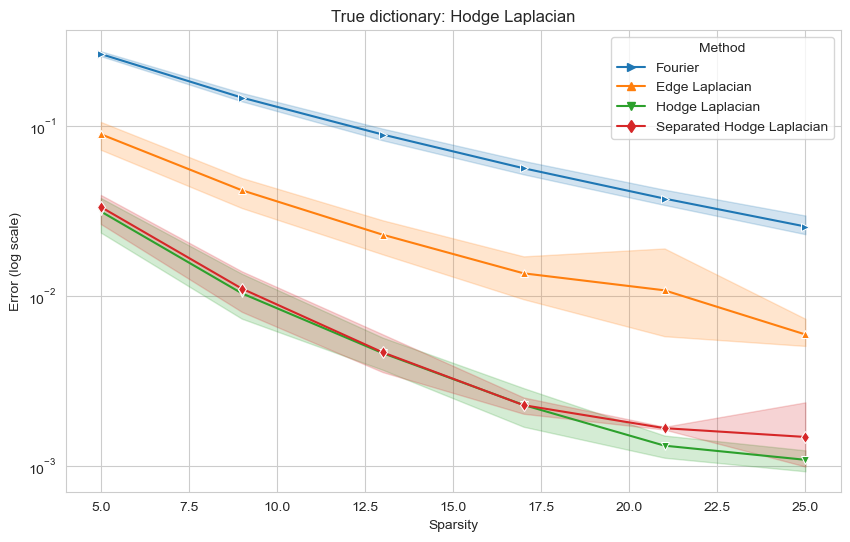

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

TITLE = [dict_types[typ] for typ in dict_types.keys() if typ in dictionary_type][0]

res_df = pd.DataFrame()
dict_types = {"fou": "Fourier", "edge": "Edge Laplacian", "joint": "Hodge Laplacian", "sep": "Separated Hodge Laplacian"}

for d in dict_types.items():
    for sim in range(n_sim):
        tmp_df = pd.DataFrame()   
        tmp_df["Error"] = eval(f'min_error_{d[0]}_test[sim,:]')
        tmp_df["Sparsity"] = K0_coll
        tmp_df["Method"] = d[1]
        res_df = pd.concat([res_df, tmp_df])

plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
my_plt = sns.lineplot(data=res_df, x='Sparsity', y='Error', hue='Method',
                       palette=sns.color_palette(),
                       markers=['>', '^', 'v', 'd'], dashes=False, style='Method')
my_plt.set(yscale='log')
my_plt.set_title(f'True dictionary: {TITLE}')
my_plt.set_ylabel('Error (log scale)')
plt.show()

# Save variables and workspace

In [19]:
import pickle
import os
import dill

save_var = {"min_error_edge_test":min_error_edge_test,
            "min_error_edge_train":min_error_edge_train,
            "min_error_fou_test":min_error_fou_test,
            "min_error_fou_train":min_error_fou_train,
            "min_error_joint_test":min_error_joint_test,
            "min_error_joint_train":min_error_joint_train,
            "min_error_sep_test":min_error_sep_test,
            "min_error_sep_train":min_error_sep_train}

PATH = os.getcwd()
DIR_PATH = f'{PATH}\\results\\{dictionary_type}'
FILENAME_ERR = f'{DIR_PATH}\\error.pkl'
FILENAME_ENV = f'{DIR_PATH}\\ipynb_env.db'
FILENAME_PLT = f'{DIR_PATH}\\plot.png'

if not os.path.exists(DIR_PATH):
    os.makedirs(DIR_PATH)
    
with open(FILENAME_ERR, 'wb') as f: 
    pickle.dump(save_var, f)
f.close()

dill.dump_session(FILENAME_ENV)

fig = my_plt.get_figure()
fig.savefig(FILENAME_PLT)

# Vettorizzazione for esterni

In [ ]:
# import scipy.io
# mat = scipy.io.loadmat('datiSC.mat')
# B1 = mat["B1"]
# B2 = mat["B2"]

# # Subsampling if needed to decrease complexity
# sub_size = 100
# B1 = B1[:, :sub_size]
# B2 = B2[:sub_size, :]
# B2 = B2[:,np.sum(np.abs(B2), 0) == 3]

# # Laplacians
# Ld = np.matmul(np.transpose(B1), B1, dtype=float)
# Lu = np.matmul(B2, np.transpose(B2), dtype=float)
# L = Lu+Ld
# n =  L.shape[0]
# nu = B2.shape[1]
# nd = B1.shape[1]
# _ ,U = la.eig(L)

# # Problem and Dictionary Dimensionalities
# dictionary_type_true = "separated"
# m_train = 150 # Number of Train Signals
# m_test = 80 # Number of Test Signal
# s_true = 3 # Number of Kernels (Sub-dictionaries)
# k_true = 2 # Polynomial order
# sparsity = .1 # Sparsity percentage
# K0_max = 20 #floor(n*sparsity) # Sparsity
# sparsity_mode = "max"

# # Data-Independent Problem Hyperparameters
# dictionary_type = dictionary_type_true
# s = s_true
# k = k_true
# K0_coll = np.arange(5, 26, 4) # K0_coll = 5:4:25 %4:4:40 %5:3:20
# lambda_ = 1e-6 # l2 multiplier
# max_iter = 100 # Maximum number of iterations
# patience = 5 # Patience
# tol = 1e-7 # Tolerance for Patience
# n_sim = 10
# verbose = 0
# # for sim in range(5,n_sim):
# tmp_res = pd.DataFrame()
# def vectorized_generation(Lu,Ld,m_train,m_test,s, K, K0, dictionary_type, sparsity_mode):
#     D_try, h, Y_train_try, Y_test_try, epsilon_try, c_try, X_train_try, X_test_try = create_ground_truth(Lu,
#                                                                                 Ld,
#                                                                                 m_train,
#                                                                                 m_test, 
#                                                                                 s=s, 
#                                                                                 K=K, 
#                                                                                 K0=K0, 
#                                                                                 dictionary_type=dictionary_type, 
#                                                                                 sparsity_mode=sparsity_mode)
#     res_dict ={"D_try":D_try,
#             "h":h,
#             "Y_train_try":Y_train_try,
#             "Y_test_try":Y_test_try,
#             "epsilon_try":epsilon_try,
#             "c_try":c_try,
#             "X_train_try":X_train_try,
#             "X_test_try":X_test_try}
#     return res_dict

# def vectorized_verify(row, K0_max, acc_tresh):
#     D_try=row["D_try"]
#     Y_train_try=row["Y_train_try"]
#     X_train_try=row["X_train_try"]
#     max_possible_sparsity, acc = verify_dic(D_try, Y_train_try, X_train_try, K0_max, acc_tresh)
#     row["acc"] = acc
#     row["max_s"] = max_possible_sparsity
#     return row

# tmp_res["search"] = np.arange(3000)
# tmp_res["res_dict"] = tmp_res.search.apply(lambda row: vectorized_generation(Lu,Ld,m_train,m_test,s=s, K=k, K0=K0_max, dictionary_type=dictionary_type, sparsity_mode=sparsity_mode))
# tmp_res["res_dict"] = tmp_res.res_dict.apply(lambda row:  vectorized_verify(row, K0_max, 0.7))